In [1]:
"""
Learning to optimize parametric Quadratic Programming (pQP)
Problem formulation pQP:
    minimize     x^2 + y^2
    subject to
               -x - y + p1 <= 0,
               x + y - p1 - 1 <= 0,
               x - y + p2 - 1 <= 0,
               -x + y - p2 <= 0


An initial prediction of the solution is made by a neural network,
then a final layer is added to apply a trainable optimization routine for improved solutions.
"""



'\nLearning to optimize parametric Quadratic Programming (pQP)\nProblem formulation pQP:\n    minimize     x^2 + y^2\n    subject to\n               -x - y + p1 <= 0,\n               x + y - p1 - 1 <= 0,\n               x - y + p2 - 1 <= 0,\n               -x + y - p2 <= 0\n\n\nAn initial prediction of the solution is made by a neural network,\nthen a final layer is added to apply a trainable optimization routine for improved solutions.\n'

In [2]:
import cvxpy as cp
import numpy as np
import time
import torch
import torch.nn as nn
import neuromancer.slim as slim
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node

from neuromancer.modules import lopo

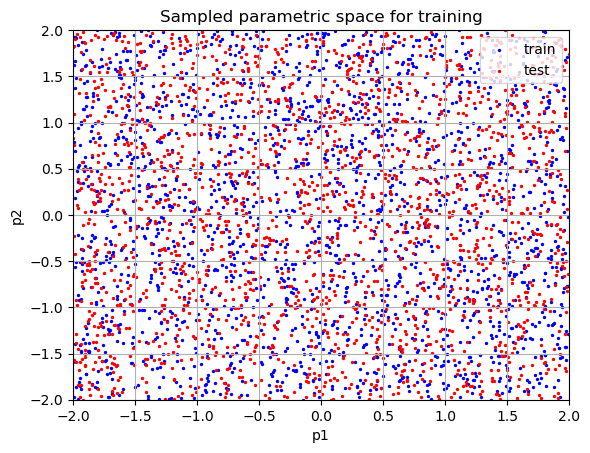

In [3]:

"""
# # #  Dataset
"""
data_seed = 408
np.random.seed(data_seed)
nsim = 2000 # number of datapoints: increase sample density for more robust results
# create dictionaries with sampled datapoints with uniform distribution
p_low, p_high = -2.0, 2.0
samples_train = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                    "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_dev = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
samples_test = {"p1": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high),
                "p2": torch.FloatTensor(nsim, 1).uniform_(p_low, p_high)}
# create named dictionary datasets
train_data = DictDataset(samples_train, name='train')
dev_data = DictDataset(samples_dev, name='dev')
test_data = DictDataset(samples_test, name='test')
# create torch dataloaders for the Trainer
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers=0,
                                            collate_fn=train_data.collate_fn, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=100, num_workers=0,
                                            collate_fn=dev_data.collate_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, num_workers=0,
                                            collate_fn=test_data.collate_fn, shuffle=True)
# note: training quality will depend on the DataLoader parameters such as batch size and shuffle

# visualize taining and test samples for 2D parametric space
a_train = samples_train['p1'].numpy()
p_train = samples_train['p2'].numpy()
a_dev = samples_dev['p1'].numpy()
p_dev = samples_dev['p2'].numpy()
plt.figure()
plt.scatter(a_train, p_train, s=2., c='blue', marker='o')
plt.scatter(a_dev, p_dev, s=2., c='red', marker='o')
plt.title('Sampled parametric space for training')
plt.xlim(p_low, p_high)
plt.ylim(p_low, p_high)
plt.grid(True)
plt.xlabel('p1')
plt.ylabel('p2')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.show(block=True)


In [4]:

"""
# # #  pQP primal solution map architecture
"""
# define neural architecture for the solution map
func = blocks.MLP(insize=2, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=nn.ReLU,
                hsizes=[80] * 4)
# define symbolic solution map with concatenated features (problem parameters)
xi = lambda p1, p2: torch.cat([p1, p2], dim=-1)
features = Node(xi, ['p1', 'p2'], ['xi'], name='features')
sol_map = Node(func, ['xi'], ['x'], name='map')
# trainable components of the problem solution
components = [features, sol_map]
"""
# # #  mpQP objective and constraints formulation in Neuromancer
"""
# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p1 = variable('p1')
p2 = variable('p2')
# objective function
f = x ** 2 + y ** 2
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]
# constraints
Q_con = 100.
g1 = -x - y + p1
con_1 = Q_con * (g1 <= 0)
con_1.name = 'c1'
g2 = x + y - p1 - 1
con_2 = Q_con*(g2 <= 0)
con_2.name = 'c2'
g3 = x - y + p2 - 1
con_3 = Q_con*(g3 <= 0)
con_3.name = 'c3'
g4 = -x + y - p2
con_4 = Q_con*(g4 <= 0)
con_4.name = 'c4'
constraints = [con_1, con_2, con_3, con_4]
"""
# # #  pQP problem formulation in Neuromancer
"""
# create penalty method loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)

In [5]:
"""
# # #  pQP problem solution in Neuromancer
"""
optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=200,
    patience=200,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)
# Train solution map
best_model = trainer.train()

epoch: 0  train_loss: 90.23594665527344
epoch: 1  train_loss: 6.634145259857178
epoch: 2  train_loss: 1.4375078678131104
epoch: 3  train_loss: 1.2274266481399536
epoch: 4  train_loss: 1.1255372762680054
epoch: 5  train_loss: 1.0753214359283447
epoch: 6  train_loss: 1.080080509185791
epoch: 7  train_loss: 1.114688754081726
epoch: 8  train_loss: 1.075182557106018
epoch: 9  train_loss: 1.0253404378890991
epoch: 10  train_loss: 1.0870329141616821
epoch: 11  train_loss: 1.1060527563095093
epoch: 12  train_loss: 1.0909936428070068
epoch: 13  train_loss: 1.1850576400756836
epoch: 14  train_loss: 1.1283657550811768
epoch: 15  train_loss: 1.0158841609954834
epoch: 16  train_loss: 1.0405914783477783
epoch: 17  train_loss: 1.2160158157348633
epoch: 18  train_loss: 1.0957300662994385
epoch: 19  train_loss: 1.2250051498413086
epoch: 20  train_loss: 1.1568043231964111
epoch: 21  train_loss: 1.113166332244873
epoch: 22  train_loss: 1.061004877090454
epoch: 23  train_loss: 1.0055105686187744
epoch: 24

In [6]:
'''
Add on a correction layer
'''
'''
DEFINE THE OBJECTIVE
'''
def f_obj(x,parms):
    return torch.pow( x[0] ,2) + torch.pow( x[1], 2)
'''
DEFINE THE CONSTRAINTS
'''
def F_ineq(x,parms):
    c_1 = -x[0] - x[1] + parms[0]
    c_2 = x[0] + x[1] - parms[0] - 1 
    c_3 = x[0] - x[1] + parms[1] - 1 
    c_4 = -x[0] + x[1] - parms[1]
    return torch.stack((c_1,c_2,c_3,c_4))
''' 
SET PROBLEM PARAMETERS
'''
num_steps = 15 # number of DR iterations to take
x_dim = 2 # dimension of primal variable
n_ineq = 4 #number of inequality constraints
parm_dim = 2 #dimension of parameters for problem
''' 
INITIALIZE THE SOLVER
Can choose either DR or ADMM here
'''
solver = 'DR'
#solver = 'ADMM'

#Define a metric that will be trained
lb_P = 1.0/5.0
ub_P = 5.0
scl_lb_P = 0.005
scl_ub_P = 1.0
n_dim = x_dim + n_ineq
metric = lopo.ParaMetricDiagonal(n_dim,parm_dim,ub_P,lb_P,scl_upper_bound=scl_ub_P,scl_lower_bound=scl_lb_P)

if solver == 'DR':
    solver = lopo.DRSolver(
        f_obj = f_obj, 
        F_ineq = F_ineq,
        x_dim = x_dim, 
        n_ineq = n_ineq, 
        JF_fixed=True,
        Hf_fixed = True,
        num_steps = num_steps,
        metric = metric
        )
if solver == 'ADMM':
    solver = lopo.ADMMSolver(
        f_obj = f_obj, 
        F_ineq = F_ineq,
        x_dim = x_dim, 
        n_ineq = n_ineq, 
        JF_fixed=True,
        Hf_fixed = True,
        num_steps = num_steps,
        metric = metric
        )
'''
REMAP THROUGH SOLVER CORRECTION
'''
sol_map = Node(func, ['xi'], ['x_predicted'], name='map')
correction = Node(solver,['x_predicted','xi'],['x','cnv_gap'])
components = [features, sol_map, correction]
### ADD A CONVERGENCE PENALTY TO TRAIN SOLVER
cnv_gap = variable("cnv_gap")
f_cnv = cnv_gap
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []
# create loss function
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
'''  
TRAIN THE METRIC
'''
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-2)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_loader,
    optimizer,
    epochs=20,
    patience=200,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)
# Train solution map
best_model = trainer.train()

epoch: 0  train_loss: 31.22165298461914
epoch: 1  train_loss: 0.18285268545150757
epoch: 2  train_loss: 0.0695408433675766
epoch: 3  train_loss: 0.051941514015197754
epoch: 4  train_loss: 0.04589463025331497
epoch: 5  train_loss: 0.04293334111571312
epoch: 6  train_loss: 0.041515007615089417
epoch: 7  train_loss: 0.039192553609609604
epoch: 8  train_loss: 0.03725047782063484
epoch: 9  train_loss: 0.03550811856985092
epoch: 10  train_loss: 0.03533368557691574
epoch: 11  train_loss: 0.033375333994627
epoch: 12  train_loss: 0.033615998923778534
epoch: 13  train_loss: 0.033002011477947235
epoch: 14  train_loss: 0.03152785077691078
epoch: 15  train_loss: 0.03035878576338291
epoch: 16  train_loss: 0.03075101412832737
epoch: 17  train_loss: 0.03005122020840645
epoch: 18  train_loss: 0.02916220761835575
epoch: 19  train_loss: 0.029255706816911697


/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_78248/2211610453.py:36: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4,cmap = mpl.colormaps['bone'],linewidth = 10)
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_78248/2211610453.py:46: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg1.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_78248/2211610453.py:48: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg2.collections,
/var/folders/5t/0jpw47ds3rs3_fzmw9fk919w0000gn/T/ipykernel_78248/2211610453.py:50: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  plt.setp(cg3.collect

primal solution x=[0.5], y=[-0.75]
parameter p=(-1.25, -1.25)
primal solution Neuromancer x1=0.5000133514404297, x2=-0.7499646544456482
primal solution x=[0.5], y=[-0.5]
parameter p=(-1.0, -1.0)
primal solution Neuromancer x1=0.4999965727329254, x2=-0.5000367164611816
primal solution x=[0.25], y=[-0.25]
parameter p=(-0.5, -0.5)
primal solution Neuromancer x1=0.2500142753124237, x2=-0.2500176727771759
primal solution x=[0.125], y=[-0.125]
parameter p=(-0.25, -0.25)
primal solution Neuromancer x1=0.12497363984584808, x2=-0.12498785555362701
primal solution x=[0.], y=[0.]
parameter p=(0.0, 0.0)
primal solution Neuromancer x1=2.333521842956543e-05, x2=-1.763179898262024e-05
primal solution x=[0.125], y=[0.125]
parameter p=(0.25, 0.25)
primal solution Neuromancer x1=0.12502098083496094, x2=0.1250094771385193
primal solution x=[0.25], y=[0.25]
parameter p=(0.5, 0.5)
primal solution Neuromancer x1=0.25002366304397583, x2=0.24999505281448364
primal solution x=[0.5], y=[0.5]
parameter p=(1.0, 1

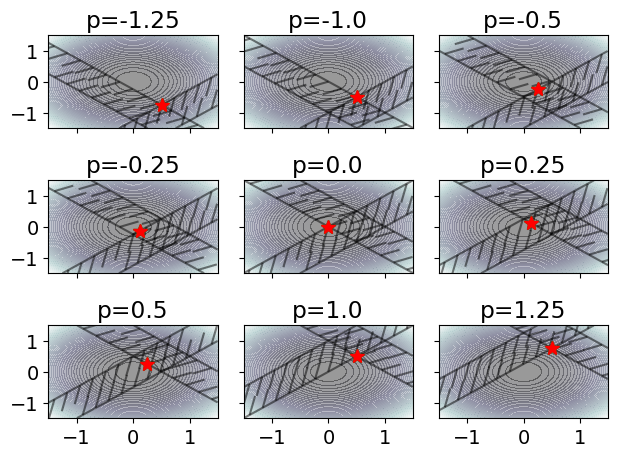

Solution for 2000 problems via CVXPY obtained in 12.6172 seconds
CVXPY mean constraints violation 0.0000
CVXPY mean objective value 0.7468

Neuromancer mean constraints violation no correction 0.0003
Neuromancer mean objective value no correction 0.9558
MSE primal optimizers no correction: 0.04138828316968836
mean objective value discrepancy np correction: 27.97 % 

Solution for 2000 problems with correction obtained in 0.0175 seconds
mean constraints violation with correction 0.0000
mean objective value with correction 0.7468
Solution speedup factor 722.8360
MSE primal optimizers: 9.141520029834998e-10
mean objective value discrepancy: 0.00 %


In [7]:
'''
Compare to CVXPY Solver
'''
"""
CVXPY benchmarks
"""
# Define the CVXPY problems.
def QP_param(p1, p2):
    x = cp.Variable(1)
    y = cp.Variable(1)
    prob = cp.Problem(cp.Minimize(x ** 2 + y ** 2),
                        [-x - y + p1 <= 0,
                        x + y - p1 - 1 <= 0,
                        x - y + p2 - 1 <= 0,
                        -x + y - p2 <= 0])
    return prob, x, y
"""
Plots
"""
import matplotlib as mpl
plt.rcParams.update({'font.size': 14})
# test problem parameters
params = [-1.25, -1.0, -0.5, -0.25, 0.0, 0.25, 0.5, 1.0, 1.25]
x1 = np.arange(-1.5, 1.5, 0.01)
y1 = np.arange(-1.5, 1.5, 0.01)
xx, yy = np.meshgrid(x1, y1)
fig, ax = plt.subplots(3,3,sharex = True,sharey=True)
row_id = 0
column_id = 0
for i, p in enumerate(params):
    if i % 3 == 0 and i != 0:
        row_id += 1
        column_id = 0
    # eval and plot objective and constraints
    J = xx ** 2 + yy ** 2
    cp_plot = ax[row_id, column_id].contourf(xx, yy, J, 50, alpha=0.4,cmap = mpl.colormaps['bone'],linewidth = 10)
    ax[row_id, column_id].set_title(f'p={p}')
    c1 = xx + yy - p
    c2 = -xx - yy + p + 1
    c3 = -xx + yy - p + 1
    c4 = xx - yy + p
    cg1 = ax[row_id, column_id].contour(xx, yy, c1, [0], colors='k', alpha=0.5)
    cg2 = ax[row_id, column_id].contour(xx, yy, c2, [0], colors='k', alpha=0.5)
    cg3 = ax[row_id, column_id].contour(xx, yy, c3, [0], colors='k', alpha=0.5)
    cg4 = ax[row_id, column_id].contour(xx, yy, c4, [0], colors='k', alpha=0.5)
    plt.setp(cg1.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.5)
    plt.setp(cg2.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.5)
    plt.setp(cg3.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.5)
    plt.setp(cg4.collections,
                path_effects=[patheffects.withTickedStroke()], alpha=0.5)
    # Solve CVXPY problem
    prob, x, y = QP_param(p, p)
    prob.solve()
    # Solve via neuromancer
    datapoint = {'p1': torch.tensor([[p]]), 'p2': torch.tensor([[p]]),
                    'name': 'test'}
    model_out = problem(datapoint)
    x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
    y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
    print(f'primal solution x={x.value}, y={y.value}')
    print(f'parameter p={p, p}')
    print(f'primal solution Neuromancer x1={x_nm}, x2={y_nm}')
    # Plot optimal solutions
    ax[row_id, column_id].plot(x.value, y.value, 'g*', markersize=10)
    ax[row_id, column_id].plot(x_nm, y_nm, 'r*', markersize=10)
    column_id += 1
fig.tight_layout()
plt.show()
plt.show(block=True)
plt.interactive(False)
"""
Benchmark Solution
"""
def eval_constraints(x, y, p1, p2):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, -x - y + p1)
    con_2_viol = np.maximum(0, x + y - p1 - 1)
    con_3_viol = np.maximum(0, x - y + p2 - 1)
    con_4_viol = np.maximum(0, -x + y - p2)
    con_viol = con_1_viol + con_2_viol + con_3_viol + con_4_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean
def eval_objective(x, y, a1=1, a2=1):
    obj_value_mean = np.mean(a1 * x**2 + a2 * y**2)
    return obj_value_mean
# Solve via neuromancer
with torch.no_grad():
    t = time.time()
    samples_test['name'] = 'test'
    model_out = problem(samples_test)
    nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()
x_nm_noDR = model_out['test_x_predicted'][:, [0]].detach().numpy()
y_nm_noDR = model_out['test_x_predicted'][:, [1]].detach().numpy()
# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, nsim):
    p1 = samples_test['p1'][i].detach().numpy()
    p2 = samples_test['p2'][i].detach().numpy()
    prob, x, y = QP_param(p1, p2)
    prob.solve(solver='ECOS_BB', verbose=False)
    prob.solve()
    x_solver.append(x.value)
    y_solver.append(y.value)
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)
p1_vec = samples_test['p1'].detach().numpy()
p2_vec = samples_test['p2'].detach().numpy()

# Evaluate solver solution
print(f'Solution for {nsim} problems via CVXPY obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p1_vec, p2_vec)
print(f'CVXPY mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'CVXPY mean objective value {solver_obj_mean:.4f}\n')

# Evaluate neuromancer solution no DR
nm_con_viol_mean = eval_constraints(x_nm_noDR, y_nm_noDR, p1_vec, p2_vec)
print(f'Neuromancer mean constraints violation no correction {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm_noDR, y_nm_noDR)
print(f'Neuromancer mean objective value no correction {nm_obj_mean:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm_noDR)[:,0]
dy = (y_solver - y_nm_noDR)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers no correction:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy np correction: {err_obj:.2f} % \n')



# Evaluate neuromancer solution
print(f'Solution for {nsim} problems with correction obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p1_vec, p2_vec)
print(f'mean constraints violation with correction {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'mean objective value with correction {nm_obj_mean:.4f}')


# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers0
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
err_primal = np.mean((dx**2 + dy**2))
rel_err_primal = np.mean((dx**2 + dy**2))/np.mean((x_solver**2 + y_solver**2 ))
print('MSE primal optimizers:', rel_err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')


